In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Importation packages :**

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import DistanceMetric
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from sklearn.linear_model import *
from sklearn.neighbors import *
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

# **Importation données :**

In [3]:
ticket = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/data/ticket_data.csv")
city = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/data/cities.csv")
station = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/data/stations.csv")
provide = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data/data/providers.csv")
pd.set_option('display.max_columns', None)

# **Affichage données absentes :**

In [4]:
datasets = [city, provide, station, ticket]
titles = ["city", "provide",  "station", "ticket"]

#To gather practical information about all datasets 
info_df = pd.DataFrame({},)
#table titles
info_df["dataset"]= titles
#columns" name
info_df["cols"] = [", ".join([col for col, null in df.isnull().sum().items() ]) for df in datasets]
#number of columns
info_df["cols_no"]= [df.shape[1] for df in datasets]
#number of missing data in the table
info_df["null_no"]= [df.isnull().sum().sum() for df in datasets]
#number of columns having the missing data
info_df["null_cols_no"]= [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
#name of columns with missing data
info_df["null_cols"] = [", ".join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
info_df.style.background_gradient(cmap="coolwarm")

,dataset,cols,cols_no,null_no,null_cols_no,null_cols
0,city,"id, local_name, unique_name, latitude, longitude, population",6,7672,2,"unique_name, population"
1,provide,"id, company_id, provider_id, name, fullname, has_wifi, has_plug, has_adjustable_seats, has_bicycle, transport_type",10,26,5,"provider_id, has_wifi, has_plug, has_adjustable_seats, has_bicycle"
2,station,"id, unique_name, latitude, longitude",4,0,0,
3,ticket,"id, company, o_station, d_station, departure_ts, arrival_ts, price_in_cents, search_ts, middle_stations, other_companies, o_city, d_city",12,165764,4,"o_station, d_station, middle_stations, other_companies"


# **Traitement des données :**

In [5]:
duree = pd.to_datetime(ticket["arrival_ts"]) - pd.to_datetime(ticket["departure_ts"])
ticket.insert(ticket.columns.get_loc("price_in_cents"), "duree", duree)
ticket.insert(ticket.columns.get_loc("search_ts"), "price_in_euros", ticket["price_in_cents"]/100)
print(ticket.shape)
ticket.head()

(74168, 14)


,id,company,o_station,d_station,departure_ts,arrival_ts,duree,price_in_cents,price_in_euros,search_ts,middle_stations,other_companies,o_city,d_city
0,6795025,8385,NaN,NaN,2017-10-13 14:00:00+00,2017-10-13 20:10:00+00,0 days 06:10:00,4550,45.5,2017-10-01 00:13:31.327+00,NaN,NaN,611,542
1,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,0 days 17:50:00,1450,14.5,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542
2,6795027,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 21:24:00+00,1 days 07:57:00,7400,74.0,2017-10-01 00:13:40.212+00,"{798,798,6794,6246}","{8377,8376}",611,542
3,6795028,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 11:02:00+00,0 days 21:35:00,13500,135.0,2017-10-01 00:13:40.213+00,"{798,798,6794,6246}","{8377,8376}",611,542
4,6795029,8381,5905.0,6495.0,2017-10-13 21:46:00+00,2017-10-14 19:32:00+00,0 days 21:46:00,7710,77.1,2017-10-01 00:13:40.213+00,"{5983,5983}",{8380},611,542


In [6]:
print(city.shape)
city.head()

(8040, 6)


,id,local_name,unique_name,latitude,longitude,population
0,5159,"Padua, Veneto, Italia",padua,45.406435,11.876761,209678.0
1,76,"Barcelona, Cataluña, España",barcelona,41.385064,2.173404,1611822.0
2,81,"Basel, Basel-Stadt, Schweiz",basel,47.593437,7.619812,NaN
3,259,"Erlangen, Bayern, Deutschland",erlangen,49.589674,11.011961,105412.0
4,11979,"Balș, Olt, România",balș,44.353354,24.095672,NaN


In [7]:
print(station.shape)
station.head()

(11035, 4)


,id,unique_name,latitude,longitude
0,1,Aalen (Stuttgarter Straße),48.835296,10.092956
1,2,Aéroport Bordeaux-Mérignac,44.830226,-0.700883
2,3,Aéroport CDG,49.009900,2.559310
3,4,Aéroport de Berlin-Schönefeld,52.389446,13.520345
4,5,Aéroport de Dresden,51.123604,13.764737


In [8]:
print(provide.shape)
provide.head()

(227, 10)


,id,company_id,provider_id,name,fullname,has_wifi,has_plug,has_adjustable_seats,has_bicycle,transport_type
0,9,1,NaN,ouibus,Ouibus,True,True,True,False,bus
1,10,2,NaN,deinbus,Deinbus.de,False,False,False,False,bus
2,11,3,NaN,infobus,Infobus,False,False,False,False,bus
3,12,4,NaN,studentAgency,Student Agency,False,False,False,False,bus
4,13,5,NaN,flixbus,Flixbus,True,False,False,False,bus


In [9]:
ticket[["price_in_cents", "duree"]].describe()

,price_in_cents,duree
count,74168.000000,74168
mean,4382.711061,0 days 07:04:37.247600043
std,3739.325367,0 days 09:54:58.881351022
min,300.000000,0 days 00:20:00
25%,1900.000000,0 days 03:00:00
50%,3350.000000,0 days 04:50:00
75%,5250.000000,0 days 08:00:00
max,38550.000000,20 days 12:51:00


In [10]:
print("Le prix minimum est de", round(ticket[["price_in_euros"]].min().price_in_euros, 3), "€\n")
print("Le prix moyen est de", round(ticket[["price_in_euros"]].mean().price_in_euros, 3), "€\n")
print("Le prix maximum est de", round(ticket[["price_in_euros"]].max().price_in_euros, 3), "€\n")
print("La durée minimale est de " + str(ticket[["duree"]].min().dt.total_seconds().duree/60), "min \n")
print("La durée moyenne est de " + str(ticket[["duree"]].mean().dt.total_seconds().duree/3600), "h \n")
print("La durée maximale est de " + str(ticket[["duree"]].max().duree))

Le prix minimum est de 3.0 €

Le prix moyen est de 43.827 €

Le prix maximum est de 385.5 €

La durée minimale est de 20.0 min 

La durée moyenne est de 7.077013222234168 h 

La durée maximale est de 20 days 12:51:00


In [11]:
ticket = ticket.merge(city, how="left", left_on="o_city", right_on="id").merge(city, how="left", left_on="d_city", right_on="id")
distance = DistanceMetric.get_metric("haversine")
ticket["distance_km"] = ticket.apply(lambda x: 6373*distance.pairwise(np.radians([[x.latitude_x, x.longitude_x], [x.latitude_y, x.longitude_y]])).item(1), axis=1)
ticket.head()

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_distance_metric.py:14: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  category=FutureWarning,


,id_x,company,o_station,d_station,departure_ts,arrival_ts,duree,price_in_cents,price_in_euros,search_ts,middle_stations,other_companies,o_city,d_city,id_y,local_name_x,unique_name_x,latitude_x,longitude_x,population_x,id,local_name_y,unique_name_y,latitude_y,longitude_y,population_y,distance_km
0,6795025,8385,NaN,NaN,2017-10-13 14:00:00+00,2017-10-13 20:10:00+00,0 days 06:10:00,4550,45.5,2017-10-01 00:13:31.327+00,NaN,NaN,611,542,611,"Orléans, Centre-Val de Loire, France",orleans,47.907018,1.90627,114977.0,542,"Montpellier, Occitanie, France",montpellier,43.604452,3.918318,275318.0,503.355132
1,6795026,9,63.0,1044.0,2017-10-13 13:05:00+00,2017-10-14 06:55:00+00,0 days 17:50:00,1450,14.5,2017-10-01 00:13:35.773+00,"{149,418}",{13},611,542,611,"Orléans, Centre-Val de Loire, France",orleans,47.907018,1.90627,114977.0,542,"Montpellier, Occitanie, France",montpellier,43.604452,3.918318,275318.0,503.355132
2,6795027,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 21:24:00+00,1 days 07:57:00,7400,74.0,2017-10-01 00:13:40.212+00,"{798,798,6794,6246}","{8377,8376}",611,542,611,"Orléans, Centre-Val de Loire, France",orleans,47.907018,1.90627,114977.0,542,"Montpellier, Occitanie, France",montpellier,43.604452,3.918318,275318.0,503.355132
3,6795028,8377,5905.0,6495.0,2017-10-13 13:27:00+00,2017-10-14 11:02:00+00,0 days 21:35:00,13500,135.0,2017-10-01 00:13:40.213+00,"{798,798,6794,6246}","{8377,8376}",611,542,611,"Orléans, Centre-Val de Loire, France",orleans,47.907018,1.90627,114977.0,542,"Montpellier, Occitanie, France",montpellier,43.604452,3.918318,275318.0,503.355132
4,6795029,8381,5905.0,6495.0,2017-10-13 21:46:00+00,2017-10-14 19:32:00+00,0 days 21:46:00,7710,77.1,2017-10-01 00:13:40.213+00,"{5983,5983}",{8380},611,542,611,"Orléans, Centre-Val de Loire, France",orleans,47.907018,1.90627,114977.0,542,"Montpellier, Occitanie, France",montpellier,43.604452,3.918318,275318.0,503.355132


In [12]:
bins = pd.IntervalIndex.from_tuples([(0, 200), (201, 800), (801, 2000), (2001, 1e9)], closed="both", dtype = pd.IntervalDtype(subtype="int"))
# cela évite de créer un intervalle supérieur à la distance maximale
if ticket["distance_km"].max() not in bins[-1]:
  bins = bins[:-1]
ticket["distance_trajet"] = pd.cut(ticket["distance_km"], bins)
provide = provide.merge(ticket, how="inner", left_on="id", right_on="company", suffixes=("_xx", "_yy"))
provide['duree'] = provide['duree'].dt.total_seconds()/3600
provide.groupby(["transport_type", "distance_trajet"])[["duree", "price_in_euros"]].agg(["min", "max", "mean", "std"])

duree                                    \
                                      min         max       mean        std   
transport_type distance_trajet                                                
bus            [0, 200]          1.083333  317.750000  10.232515  12.332009   
               [201, 800]        2.483333  492.850000  15.103924  18.428319   
               [801, 2000]      12.250000  353.000000  27.536119  25.160522   
carpooling     [0, 200]          0.333333   17.333333   1.952040   0.646641   
               [201, 800]        1.333333   19.833333   4.780698   1.897103   
               [801, 2000]       7.833333   29.166667  13.100233   4.194421   
train          [0, 200]          0.650000   34.450000   4.419400   4.331400   
               [201, 800]        1.133333   48.450000   7.685842   6.472368   
               [801, 2000]       3.550000   40.616667  12.158617   7.905640   

                               price_in_euros                                
                                          min    max        mean        std  
transport_type distance_trajet                                               
bus            [0, 200]                  8.50  229.0   21.828309  12.020504  
               [201, 800]               10.00  224.8   35.058386  15.367115  
               [801, 2000]              22.90  174.0   69.499500  24.469611  
carpooling     [0, 200]                  3.00  128.5   11.773524   4.153577  
               [201, 800]                8.50  138.0   32.311999  13.181283  
               [801, 2000]              44.96  161.5   86.265455  22.675249  
train          [0, 200]                  4.90  251.0   34.879008  20.578948  
               [201, 800]               14.00  385.5   91.363980  46.170646  
               [801, 2000]              19.40  375.5  154.637461  65.613132

# **Dataviz :**

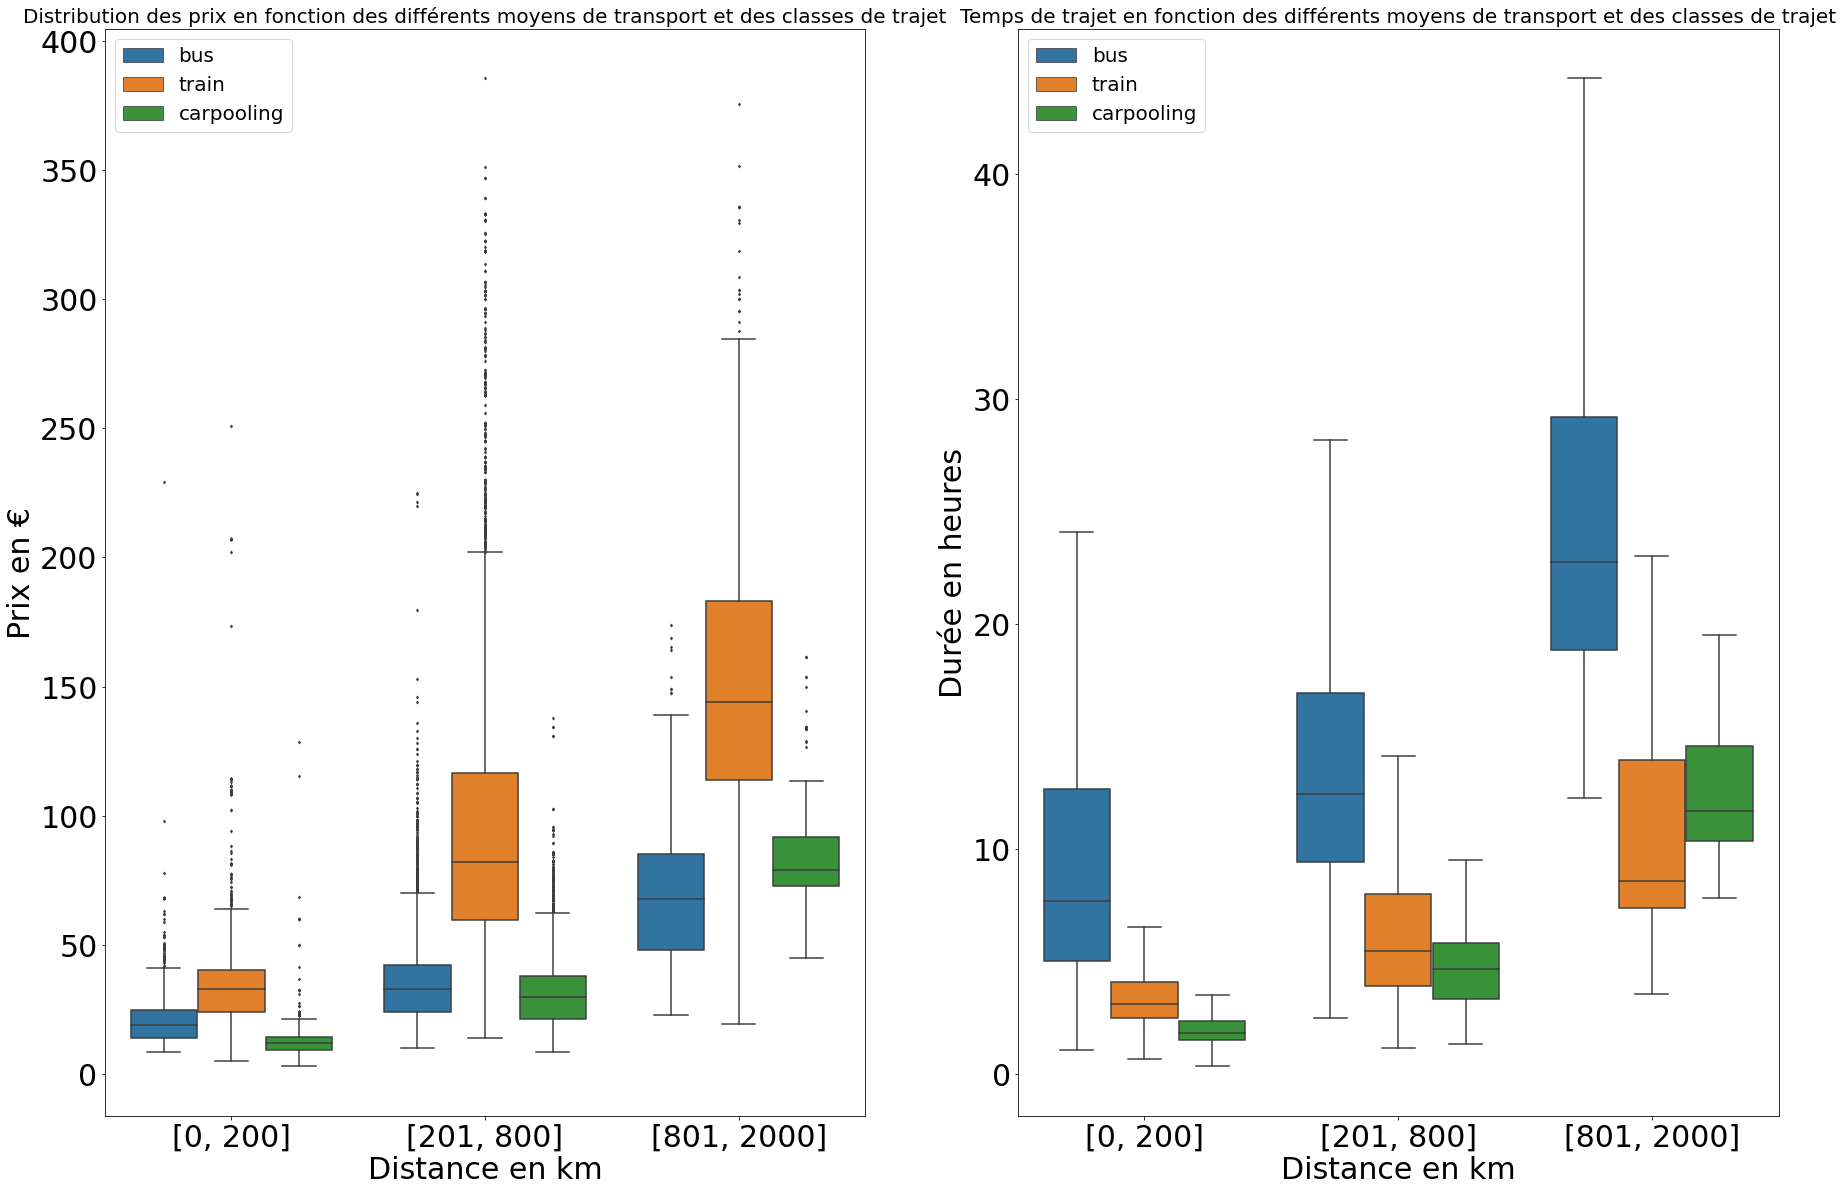

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(30, 20))

ax1 = sns.boxplot(x="distance_trajet", y="price_in_euros", hue="transport_type", data=provide, fliersize = 2, ax = axes[0])
ax1.set_title(label = "Distribution des prix en fonction des différents moyens de transport et des classes de trajet", fontsize = 20)
ax1.set_xlabel(xlabel="Distance en km", fontsize = 30)
ax1.set_ylabel(ylabel="Prix en €", fontsize = 30)
ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)
ax1.legend(loc=2, prop={'size': 20})

ax2 = sns.boxplot(x="distance_trajet", y="duree", hue="transport_type", data=provide, showfliers = False, ax = axes[1])
ax2.set_title(label = "Temps de trajet en fonction des différents moyens de transport et des classes de trajet", fontsize = 20)
ax2.set_xlabel(xlabel="Distance en km", fontsize = 30)
ax2.set_ylabel(ylabel="Durée en heures", fontsize = 30)
ax2.tick_params(axis='x', labelsize=30)
ax2.tick_params(axis='y', labelsize=30)
ax2.legend(loc=2, prop={'size': 20})

plt.show()

**Train** :
  - C'est le plus cher peu importe la distance.
  - La durée moyenne de 4h25 pour les trajets de moins de 200km est elevée du au fait de l'absence de TGV sur les plus petits trajets.
  - Pour les distances entre 801 et 2000km, le train est le plus rapide. 

**Bus** :
  - Le bus est le moyen de transport le plus lent.
  - Au-delà de 801km, c'est le bus qui est le moins cher.

**Covoiturage** :
  - Pour les distances entre 0 et 800km, le covoiturage est plus rapide.
  - C'est le moins cher pour les trajets de moins 800km.
  - C’est le meilleur rapport durée/prix indépendamment de la distance.

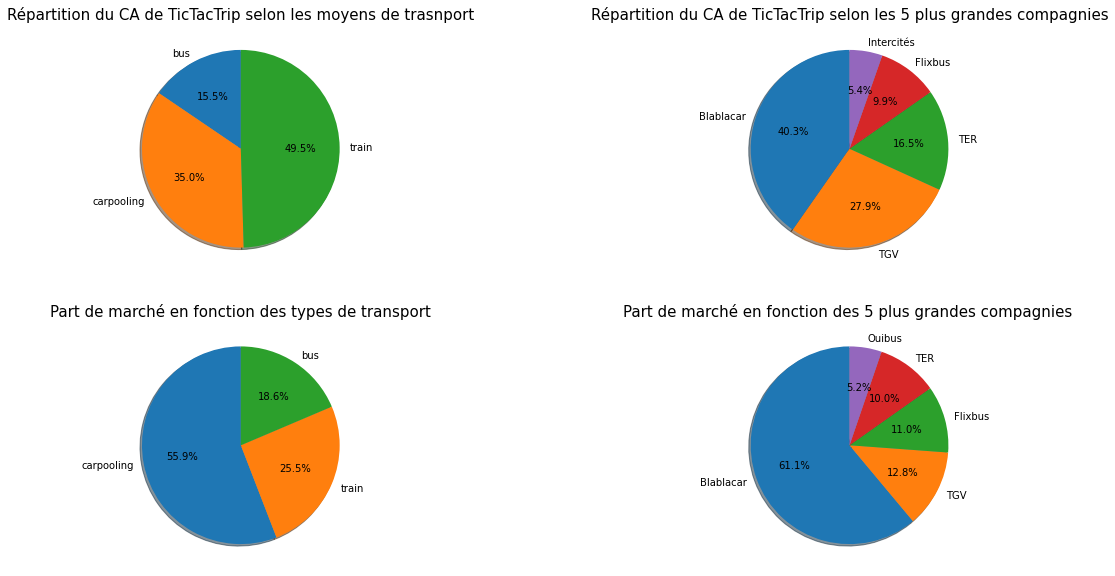

In [14]:
# détermine le CA selon chaque mode de transport
CA = provide.groupby("transport_type")["price_in_cents"].sum()
# détermine le CA selon chaque compagnies
CA_co = provide.groupby(['fullname'])['price_in_euros'].sum().sort_values(ascending=False)[:5]
# Fréquence selon différents types de transports 
freq = provide["transport_type"].value_counts()
# Fréquence selon différentes compagnies
freq_co = provide["fullname"].value_counts().sort_values(ascending=False)[:5]

fig, axes = plt.subplots(2, 2, figsize=(20, 10))

axes[0,0].pie(CA, labels=CA.keys(), autopct='%1.1f%%', shadow=True, startangle=90)
axes[0,0].set_title('Répartition du CA de TicTacTrip selon les moyens de trasnport', fontsize = 15)

axes[0,1].pie(CA_co, labels=CA_co.keys(), autopct='%1.1f%%', shadow=True, startangle=90)
axes[0,1].set_title('Répartition du CA de TicTacTrip selon les 5 plus grandes compagnies', fontsize = 15)

axes[1,0].pie(freq, labels=freq.keys(), autopct='%1.1f%%', shadow=True, startangle=90)
axes[1,0].set_title("Part de marché en fonction des types de transport", fontsize = 15)

axes[1,1].pie(freq_co, labels=freq_co.keys(), autopct='%1.1f%%', shadow=True, startangle=90)
axes[1,1].set_title("Part de marché en fonction des 5 plus grandes compagnies ", fontsize=15)

plt.show()

Le covoiturage est le moyen de transport le plus utilisé, suivi par le train puis le bus. Le train représente 25.5% des trajets mais 49.5% du chiffre d'affaire. Parmi les 5 plus grandes compagnies on remarque que seul Blablacar est présente dans la catégorie covoiturage.


In [15]:
id_station = dict(zip(station["id"], station["unique_name"]))
id_provide = dict(zip(provide["id_xx"], provide["fullname"]))
k = np.random.choice(ticket.shape[0], 10)
for (depart, arrivee), voyage in ticket.loc[k].groupby(["o_station", "d_station"]):
    
    # Informations sur les prix 
    prix_min = voyage["price_in_euros"].min()
    prix_max = voyage["price_in_euros"].max()
    prix_moy = voyage["price_in_euros"].mean()

    # Dataframe billets avec des informations sur les prix sur la base d'un départ/arrivée
    billets = pd.DataFrame([{
        "Gare de départ": id_station[depart],
        "Gare d'arrivée": id_station[arrivee],
        "Prix le plus bas en €": prix_min,
        "Prix le plus élevé €": prix_max,
        "Prix moyen en €": prix_moy
    }])

    # Affichage du trajet le moins cher
    display(HTML("<h3>From: {}".format(id_station[depart])))
    display(HTML("<h3>To: {}".format(id_station[arrivee])))
    display(billets)
    display(HTML("<h4>Trajet le moins cher :"))
    
    best_boyage = voyage.copy()
    best_boyage = best_boyage[best_boyage["price_in_euros"] == prix_min]
    best_boyage["o_station"] = best_boyage["o_station"].apply(lambda x: id_station[x])
    best_boyage["d_station"] = best_boyage["d_station"].apply(lambda x: id_station[x])
    best_boyage["company"] = best_boyage["company"].apply(lambda x: id_provide[x])
    best_boyage["middle_stations"] = best_boyage["middle_stations"].apply(lambda x: [id_station[int(y)] for y in x.strip("{}").split(",")])
    best_boyage["other_companies"] = best_boyage["other_companies"].apply(lambda x: [id_provide[int(y)] for y in x.strip("{}").split(",")])
    best_boyage = best_boyage[["o_station", "local_name_x", "d_station", "local_name_y", "middle_stations", "company", "other_companies", "departure_ts", "arrival_ts", "duree", "distance_km", "price_in_euros"]]
    
    display(best_boyage)

,Gare de départ,Gare d'arrivée,Prix le plus bas en €,Prix le plus élevé €,Prix moyen en €
0,Gare routière d'Avignon,Marne-La-Vallée - Chessy - Gare Tgv et OuiGo (...,100.2,100.2,100.2


,o_station,local_name_x,d_station,local_name_y,middle_stations,company,other_companies,departure_ts,arrival_ts,duree,distance_km,price_in_euros
71246,Gare routière d'Avignon,"Avignon, Provence-Alpes-Côte d'Azur, France",Marne-La-Vallée - Chessy - Gare Tgv et OuiGo (...,"Paris, Île-de-France, France","[Gare SNCF Lyon Part-Dieu, Gare SNCF Lyon Part...",TER,[TGV],2017-10-25 16:22:00+00,2017-10-25 20:48:00+00,0 days 04:26:00,575.971937,100.2


,Gare de départ,Gare d'arrivée,Prix le plus bas en €,Prix le plus élevé €,Prix moyen en €
0,Saint-Gilles-Croix-de-Vie,Rochefort,32.4,32.4,32.4


,o_station,local_name_x,d_station,local_name_y,middle_stations,company,other_companies,departure_ts,arrival_ts,duree,distance_km,price_in_euros
50786,Saint-Gilles-Croix-de-Vie,"Saint-Gilles-Croix-de-Vie, Pays-de-la-Loire, F...",Rochefort,"Rochefort, Nouvelle-Aquitaine, France","[Nantes Pirmil, Nantes]",Navette Keolis,[Intercités],2017-10-21 17:05:00+00,2017-10-22 11:24:00+00,0 days 18:19:00,110.899189,32.4


,Gare de départ,Gare d'arrivée,Prix le plus bas en €,Prix le plus élevé €,Prix moyen en €
0,Paris Porte de Charenton,Gare routière de Limoges,28.0,28.0,28.0


,o_station,local_name_x,d_station,local_name_y,middle_stations,company,other_companies,departure_ts,arrival_ts,duree,distance_km,price_in_euros
19434,Paris Porte de Charenton,"Paris, Île-de-France, France",Gare routière de Limoges,"Limoges, Nouvelle-Aquitaine, France","[Rue de la Bourie Rouge, Rue de la Bourie Rouge]",Eurolines,[Flixbus],2017-10-10 12:45:00+00,2017-10-10 19:55:00+00,0 days 07:10:00,344.780755,28.0


Cette boucle permet pour un itinéraire donné de déterminer le trajet le moins cher.

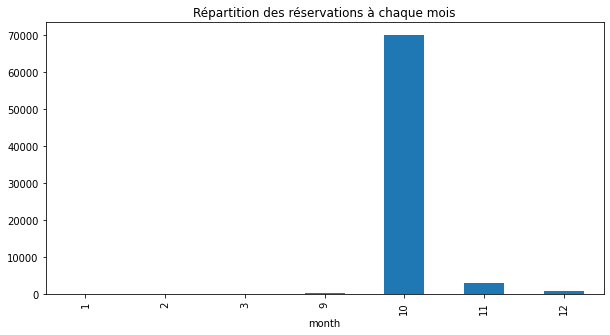

In [16]:
provide['month']=pd.DatetimeIndex(provide['departure_ts']).month
provide.groupby(['month']).size().plot(figsize=(10,5), kind='bar')
plt.title("Répartition des réservations à chaque mois")
plt.show()

# **Machine learning :**

In [17]:
# on sélectionne les variables qui permettront au mieux d'expliquer le prix 
features = ['o_city', 'd_city', 'distance_km', 'month', 'company', 'other_companies', 'middle_stations', 
            'has_wifi', 'has_plug', 'has_adjustable_seats', 'has_bicycle', 'transport_type']
X = provide[features].copy()
# on cherche le nombre de compagnies intermédiaires par ticket
X['other_companies'] = X['other_companies'].apply(lambda x: len(x.split(',')) if type(x) == str else 0)
# on cherche le nombre de stations intermédiaires par ticket
X['middle_stations'] = X['middle_stations'].apply(lambda x: len(x.split(',')) if type(x) == str else 0)
X['hour'] = pd.to_datetime(provide['departure_ts']).dt.hour
# on rempalce les NaN par la moyenne dans chaque colonne 
cat_columns = ['has_wifi', 'has_plug', 'has_adjustable_seats', 'has_bicycle', 'transport_type']
X[cat_columns] = X[cat_columns].fillna(X[cat_columns[:-1]].mean(numeric_only=False).round().astype(bool)).astype('category')
cat_columns = X[cat_columns].select_dtypes(['category']).columns
X[cat_columns] = X[cat_columns].apply(lambda x: x.cat.codes)
# on crée une colonne qui calcule l'écart entre le départ et la réservation
X['reservation'] = (pd.to_datetime(ticket["departure_ts"]) - pd.to_datetime(ticket["search_ts"])).dt.total_seconds()/3600
# on normalise les données 
x = X[['distance_km', 'reservation']]
x_scaled = scale(x)
x_scaled = pd.DataFrame(x_scaled)
X[['distance_km', 'reservation']] = x_scaled
y = scale(provide[['price_in_euros']]).reshape(-1)
# on crée un ensemble entraînement 60%, test 20% et validation 20%
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, shuffle=True)
print(x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape)

(44500, 14) (14834, 14) (14834, 14) (44500,) (14834,) (14834,)


Sur la base de la documentation de **Scikit-Learn**, https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model, https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble et notamment de sa map : https://scikit-learn.org/stable/_static/ml_map.png. On peut sélectionner une liste regroupant les algorithmes de régression qu'on aura par la suite l'occasion de réduire. Ce qui a été fait ici où l'on a gardé des algorithmes avec de faibles temps d'exécution sur les données.

LinearRegression(n_jobs=-1) :

	Score du modèle : 0.68 

	Erreur MSE : 0.31 

	Temps exécution: 0.04 s

DecisionTreeRegressor() :

	Score du modèle : 0.84 

	Erreur MSE : 0.15 

	Temps exécution: 0.64 s

ExtraTreesRegressor(n_jobs=-1) :

	Score du modèle : 0.89 

	Erreur MSE : 0.11 

	Temps exécution: 14.88 s

RandomForestRegressor(n_jobs=-1) :

	Score du modèle : 0.90 

	Erreur MSE : 0.10 

	Temps exécution: 14.62 s

DecisionTreeRegressor() :

	Score du modèle : 0.84 

	Erreur MSE : 0.15 

	Temps exécution: 0.26 s

GradientBoostingRegressor() :

	Score du modèle : 0.82 

	Erreur MSE : 0.18 

	Temps exécution: 5.30 s

HistGradientBoostingRegressor() :

	Score du modèle : 0.88 

	Erreur MSE : 0.12 

	Temps exécution: 0.87 s

KNeighborsRegressor(n_jobs=-1) :

	Score du modèle : 0.83 

	Erreur MSE : 0.17 

	Temps exécution: 0.11 s



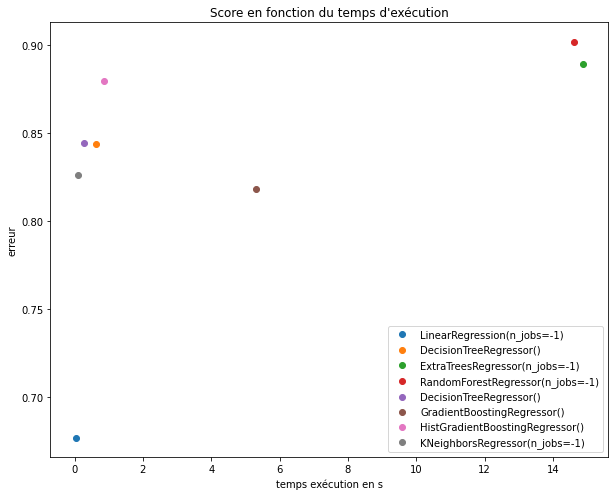

In [18]:
model = [LinearRegression(n_jobs=-1), DecisionTreeRegressor(), ExtraTreesRegressor(n_jobs=-1), 
         RandomForestRegressor(n_jobs=-1), DecisionTreeRegressor(), GradientBoostingRegressor(), 
         HistGradientBoostingRegressor(), KNeighborsRegressor(n_jobs=-1)]
plt.figure(figsize=(10,8))
for reglinear in model:
  t0 = time.time()
  reglinear.fit(x_train, y_train)
  t1 = time.time() - t0
  y_prediction = reglinear.predict(x_test)
  # on affiche le résultat du modèle sur les données de test
  print(str(reglinear) + " :\n")
  print("\tScore du modèle : %.2f" % reglinear.score(x_test, y_test), "\n")
  print("\tErreur MSE : %.2f" % mean_squared_error(y_test,y_prediction), "\n")
  print("\tTemps exécution: %.2f" % t1, "s\n")
  plt.plot(t1, reglinear.score(x_test, y_test), 'o', label = str(reglinear))
  print("="*100)
plt.title("Score en fonction du temps d'exécution")
plt.xlabel("temps exécution en s")
plt.ylabel("erreur")
plt.legend()
plt.show()

In [19]:
model = RandomForestRegressor(n_estimators=145, min_samples_split=7 , n_jobs=-1)
model.fit(x_train, y_train)
y_predtrain = model.predict(x_train)
y_predtest = model.predict(x_test)
print(("Le meilleur modèle logistique obtenu a comme performance : %.2f"
       % model.score(x_test, y_test)))
print("Les performances de l'ensemble train et test sont de : " + 
      str(100*r2_score(y_true=y_train, y_pred=y_predtrain).round(4)) + "% et " +
      str(100*r2_score(y_true=y_test, y_pred=y_predtest).round(4)) + "%.")
print("RMSE = {}".format(mean_squared_error(y_true=y_train, y_pred=y_predtrain).round(4)))
print("MAE = {}".format(mean_absolute_error(y_true=y_test, y_pred=y_predtest).round(4)))

Le meilleur modèle logistique obtenu a comme performance : 0.91
Les performances de l'ensemble train et test sont de : 96.7% et 90.67%.
RMSE = 0.033
MAE = 0.1525


On va vérifier que le modèle ne souffre pas d'un biais élevé et d'une variance élevée ce qui évitera les problèmes de sous-apprentissage et sur-apprentissage.

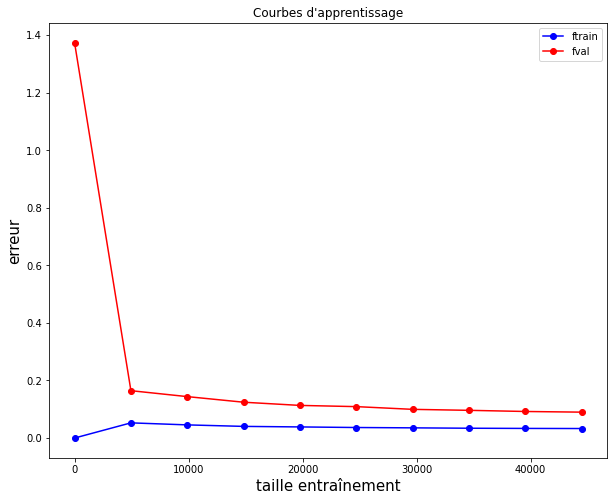

In [20]:
plt.figure(figsize=(10,8))
N, M = x_train.shape
train_size = np.linspace(1, N, 10, dtype=int, endpoint=True)
n = len(train_size)
# fonction coût entraînement et validation
ftrain = []
fval = []
for m in train_size:
  # Train
  model.fit(x_train.iloc[:m], y_train[:m])
  y_prediction = model.predict(x_train.iloc[:m])
  ftrain.append(mean_squared_error(y_train[:m], y_prediction))
  # Validation
  y_prediction_val = model.predict(x_val)
  fval.append(mean_squared_error(y_val, y_prediction_val))
# Plot
plt.plot(train_size, ftrain, 'b-o', label= 'ftrain')
plt.plot(train_size, fval, 'r-o', label= 'fval')
plt.title("Courbes d'apprentissage")
plt.xlabel(xlabel='taille entraînement', fontsize = 15)
plt.ylabel(ylabel='erreur', fontsize = 15)
plt.legend()
plt.show()

In [21]:
kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(X)
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = y[train_index], y[test_index]
    model = RandomForestRegressor(n_estimators=145, min_samples_split=7 , n_jobs=-1)
    model.fit(X_train, Y_train)
    y_predtrain = model.predict(X_train)
    y_predtest = model.predict(X_test)
    print(("Le modèle linéaire obtenu a comme performance : %.2f" % model.score(X_test, Y_test)))
    print("Les performances de l'ensemble train et test : " + 
          str(100*r2_score(y_true=Y_train, y_pred=y_predtrain).round(4)) + "% et " +
          str(100*r2_score(y_true=Y_test, y_pred=y_predtest).round(4)) + "%.")
    print("RMSE = {}".format(mean_squared_error(y_true=Y_test, y_pred=y_predtest).round(4)))
    print("MAE = {}".format(mean_absolute_error(y_true=Y_test, y_pred=y_predtest).round(4)), "\n")

Le modèle linéaire obtenu a comme performance : 0.92
Les performances de l'ensemble train et test : 96.85000000000001% et 91.67999999999999%.
RMSE = 0.0842
MAE = 0.1465 

Le modèle linéaire obtenu a comme performance : 0.91
Les performances de l'ensemble train et test : 96.94% et 91.27%.
RMSE = 0.083
MAE = 0.1463 

Le modèle linéaire obtenu a comme performance : 0.92
Les performances de l'ensemble train et test : 96.91% et 91.5%.
RMSE = 0.0842
MAE = 0.1467 

Le modèle linéaire obtenu a comme performance : 0.92
Les performances de l'ensemble train et test : 96.84% et 91.61%.
RMSE = 0.0856
MAE = 0.1494 

Le modèle linéaire obtenu a comme performance : 0.91
Les performances de l'ensemble train et test : 96.84% et 91.4%.
RMSE = 0.0882
MAE = 0.1493 



In [24]:
y_pred = model.predict(X)
print(("Le modèle linéaire obtenu a comme performance : %.2f" % model.score(X, y)))
print("La performance de l'ensemble X : " + 
      str(100*r2_score(y_true=y, y_pred=y_pred).round(4)) + "%")
print("RMSE = {}".format(mean_squared_error(y_true=y, y_pred=y_pred).round(4)))
print("MAE = {}".format(mean_absolute_error(y_true=y, y_pred=y_pred).round(4)))

Le modèle linéaire obtenu a comme performance : 0.96
La performance de l'ensemble X : 95.81%
RMSE = 0.0419
MAE = 0.1009


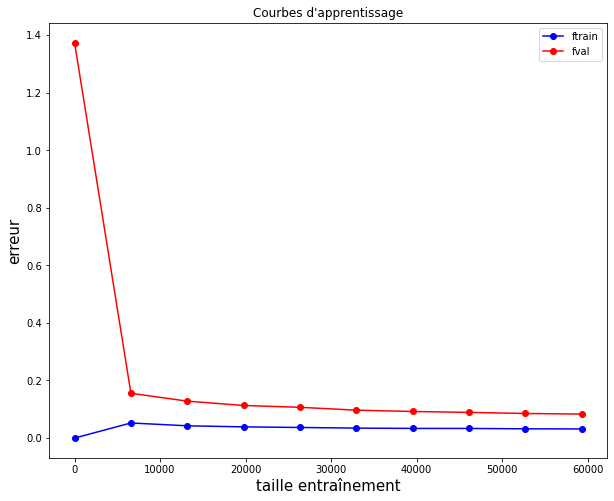

In [23]:
plt.figure(figsize=(10,8))
xx = x_train.append(x_test)
yy = np.append(y_train, y_test)
N, M = xx.shape
train_size = np.linspace(1, N, 10, dtype=int, endpoint=True)
n = len(train_size)
# fonction coût entraînement et validation
ftrain = []
fval = []
for m in train_size:
  # Train
  model.fit(xx.iloc[:m], yy[:m])
  y_prediction = model.predict(xx.iloc[:m])
  ftrain.append(mean_squared_error(yy[:m], y_prediction))
  # Validation
  y_prediction_val = model.predict(x_val)
  fval.append(mean_squared_error(y_val, y_prediction_val))
# Plot
plt.plot(train_size, ftrain, 'b-o', label= 'ftrain')
plt.plot(train_size, fval, 'r-o', label= 'fval')
plt.title("Courbes d'apprentissage")
plt.xlabel(xlabel='taille entraînement', fontsize = 15)
plt.ylabel(ylabel='erreur', fontsize = 15)
plt.legend()
plt.show()

Le modèle se comporte bien au vu des courbes d'apprentissages. On pourrait l'améliorer avec un réseau de neurones mais je n'ai obtenu qu'un score de 60% avec un réseau profond (plus de 3 couches). La recherche de la bonne architecture peut être fastidieuse. On peut conclure que pour ses données un RandomForest avec validation croisée à 5 volets peut atteindre de bons résultats.